In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib import slim
import gym
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style
style.use('ggplot')
%matplotlib inline

In [2]:
env = gym.make('MountainCar-v0')

[2016-12-14 17:29:03,413] Making new env: MountainCar-v0


In [3]:
n_actions = env.action_space.n
n_features = env.observation_space.shape[0]

ANN to aproximate Q

In [4]:
class Approximator():
    ''' Neural network to approximate Q '''
    def __init__(self, n_features, hidden_size, n_actions, learning_rate=3e-4):
        # Placeholders
        self.X = tf.placeholder(name='input', dtype=tf.float32, shape=[None,n_features])
        self.Y = tf.placeholder(name='target', dtype=tf.float32, shape=[None])
        self.a = tf.placeholder(name='action', dtype=tf.int32, shape=[None])   

        # Network body
        self.hidden = slim.fully_connected(inputs=self.X, num_outputs=hidden_size, activation_fn=tf.nn.sigmoid)      
        self.Q = slim.fully_connected(inputs=self.hidden, num_outputs=n_actions, activation_fn=None)   

        # Loss
        # Get the value only for the chosen action
        self.batch_size = tf.shape(self.X)[0]
        self.actions_indices = tf.range(self.batch_size) * tf.shape(self.Q)[1] + self.a
        self.actions_value = tf.gather(tf.reshape(self.Q, [-1]), self.actions_indices)
        # Mean squared error
        self.losses = tf.squared_difference(self.Y, self.actions_value)
        self.loss = tf.reduce_mean(self.losses)
        # Optimizer
        self.optimizer = tf.train.AdamOptimizer(learning_rate)
        # Compute and clip gradient
        self.grads_and_vars = self.optimizer.compute_gradients(self.loss)
        self.clipped_grads = [(tf.clip_by_value(gv[0], -1, 1), gv[1]) for gv in self.grads_and_vars]
        self.train_op = self.optimizer.apply_gradients(self.clipped_grads)
    
    def predict(self, sess, state):
        ''' Feed foward the network to compute Q values '''
        return sess.run(self.Q, feed_dict={self.X:state})
    
    def update(self, sess, state, target, action):
        feed_dict = {self.X:[state], self.Y:[target], self.a:[action]}
        sess.run(self.train_op, feed_dict=feed_dict)           

In [5]:
def test(n_actions, learning_rate=3e-4):
    state = env.reset()
    ''' Test if update is affecting mostly the chosen action '''
    # Reset graph
    tf.reset_default_graph()
    # Create a new graph
    Q_test = Approximator(n_features, hidden_size=8, n_actions=n_actions, learning_rate=learning_rate)
    # Aproximate actions values to 1
    target = 1
    with tf.Session() as sess:     
        tf.initialize_all_variables().run()
        for action in range(n_actions):
            # Computes Q and updates the chosen action to be closer to 1
            Q_old = Q_test.predict(sess, [state])    
            Q_test.update(sess, state, target, action)
            Q_new = Q_test.predict(sess, [state])
            print('Action: {}'.format(action))
            print('Old Q: {}\nNew Q: {}'.format(Q_old, Q_new))

In [6]:
def epolicy(Q, epsilon=0.5):
    ''' Make an epsilon greedy choice'''    
    n_actions = len(np.squeeze(Q))
    A = (np.ones(n_actions) * epsilon) / n_actions
    best_action = np.argmax(np.squeeze(Q))
    A[best_action] += (1 - epsilon)    
    return A

In [7]:
def visualize(sess, Q):
    ''' Visualize Q function '''
    # Range of states
    pos = np.linspace(-1.2, 0.6, 100)
    vel = np.linspace(-0.07, 0.07, 100)        
    # Make a grid from states
    X, Y = np.meshgrid(pos, vel) # [100, 100], [100, 100]
    # Reshape to feed to the network
    X_flat, Y_flat = X.flatten(), Y.flatten()
    states = np.c_[X_flat, Y_flat] # [10000, 2]
    # Predict Q values
    Z = Q.predict(sess, states)
    # Get max Q values
    Z_max = np.max(Z, axis=1)
    Z_max = Z_max.reshape(X.shape)
    # Plot
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(X, Y, -Z_max, cmap='jet')
    # Labels
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    # Camera angle
    ax.view_init(40, 55)
    plt.show()

In [8]:
# Test update function
test(n_actions, learning_rate=1e-2)

/home/quazar/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Action: 0
Old Q: [[-0.65415204  0.70003891 -1.19727457]]
New Q: [[-0.58963346  0.69611156 -1.19554651]]
Action: 1
Old Q: [[-0.58963346  0.69611156 -1.19554651]]
New Q: [[-0.54733974  0.73466307 -1.19516695]]
Action: 2
Old Q: [[-0.54733974  0.73466307 -1.19516695]]
New Q: [[-0.51621729  0.76042205 -1.15584159]]


In [9]:
def train(n_episodes=500, learning_rate=4e-2, discount_factor=0.99, render=False):
    print('--- Started training ---')
    # Create network
    tf.reset_default_graph()
    Q_aprox = Approximator(n_features, 10, n_actions, learning_rate)
    
    # Store statistics
    ep_length = []    

    # Intialize tensorflow session
    with tf.Session() as sess:    
        tf.initialize_all_variables().run()

        for i_episode in range(n_episodes + 1):            
            # Exponentially decay epsilon
#             epsilon = 0.01 + (1 - 0.01) * np.exp(-1e-2 * i_episode)
            epsilon = 0.2

            # Reset state
            state = env.reset()
            # Pick first action
            Q = Q_aprox.predict(sess, [state])
            action_probs = epolicy(Q, epsilon)
            action = np.random.choice(np.arange(n_actions), p=action_probs)

            # Repeat until episode is finished
            for t in itertools.count():
                if render == True:
                    env.render()
                # Perform action
                next_state, reward, done, _ = env.step(action)

                # If terminal state target in only the reward
                if done:    
                    td_target = reward
                    # Update Q
                    Q_aprox.update(sess, state, td_target, action)
                    break

                else:    
                    # Pick next action based on new state
                    Q_next = Q_aprox.predict(sess, [next_state])
                    action_probs_next = epolicy(Q_next, epsilon)
                    action_next = np.random.choice(np.arange(n_actions), p=action_probs_next)

                    # Calculate TD target
                    td_target = reward + discount_factor * Q_next[0][action_next]

                    # Update Q
                    Q_aprox.update(sess, state, td_target, action)

                    # Update next state and action
                    state = next_state
                    action = action_next   

            # Store statistics         
            ep_length.append(t)
            # Print episode information
            print('\rEpisode: {}/{}'.format(i_episode, n_episodes), end=' | ', flush=True)
            print('Episode length: {}'.format(np.mean(ep_length[-1])), end='', flush=True)            
            if i_episode % 50 == 0:
                start = i_episode - 49
                end = i_episode + 1
                print('\rEpisode: {}/{}'.format(i_episode, n_episodes), end=' | ', flush=True)
                print('Average length: {}'.format(np.mean(ep_length[start:end])), end='', flush=True)
                visualize(sess, Q_aprox)
                
    return ep_length

--- Started training ---


/home/quazar/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Episode: 0/1000 | Average length: 8658.0

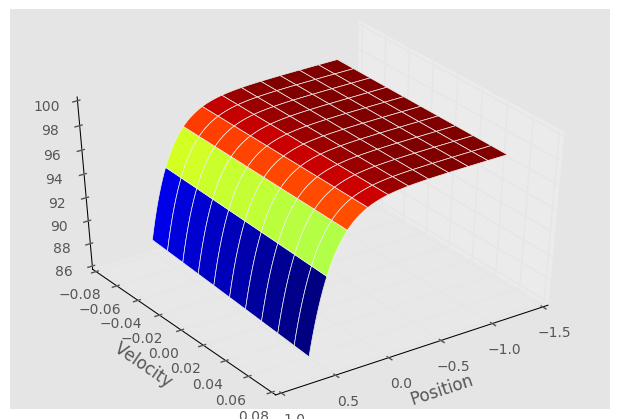

Episode: 50/1000 | Average length: 1017.86

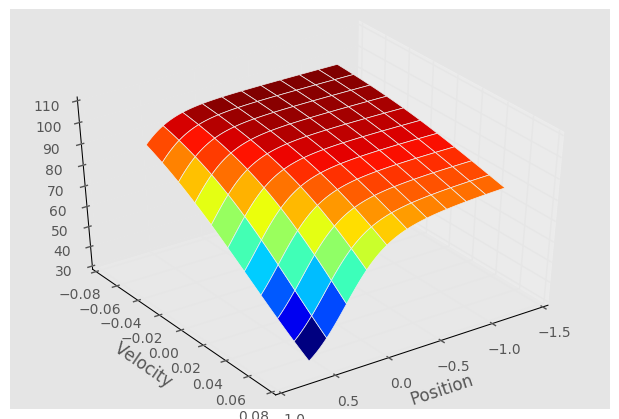

Episode: 100/1000 | Average length: 3693.6

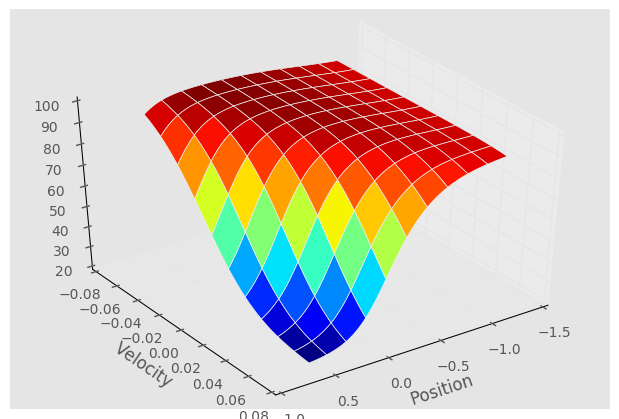

Episode: 150/1000 | Average length: 882.44

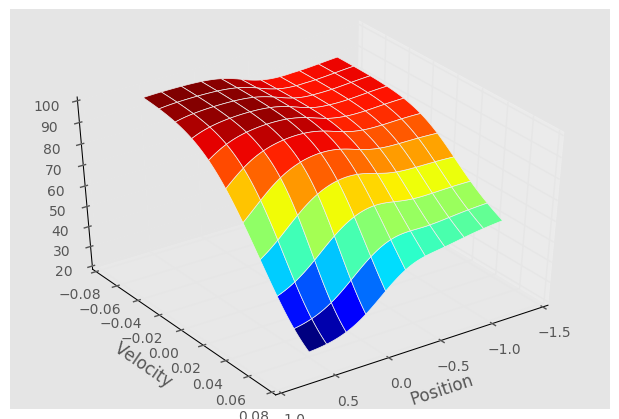

Episode: 200/1000 | Average length: 591.8

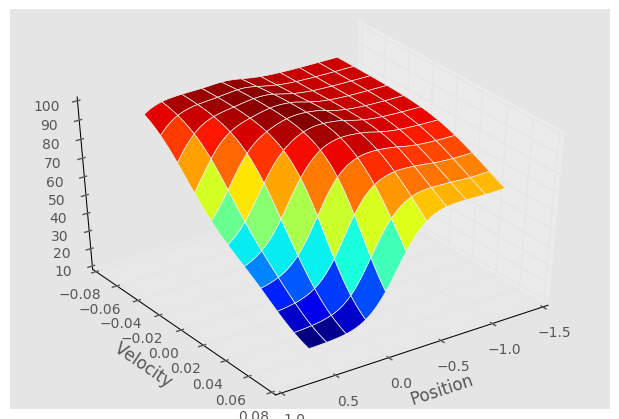

Episode: 250/1000 | Average length: 326.82

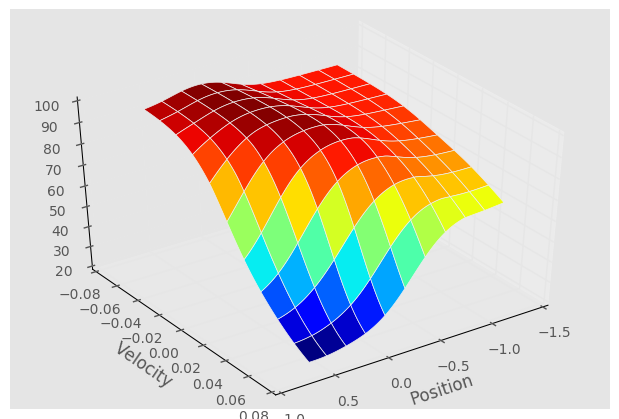

Episode: 300/1000 | Average length: 252.36

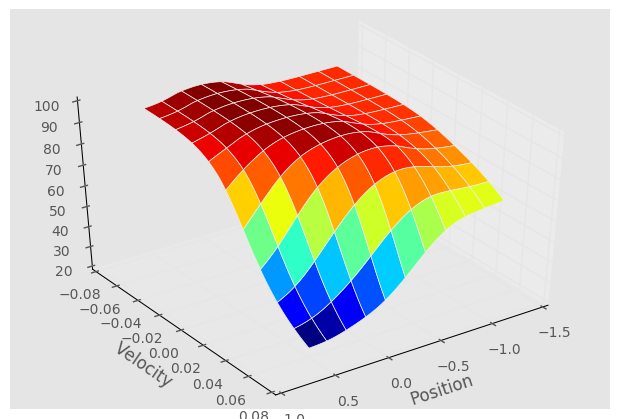

Episode: 350/1000 | Average length: 249.02

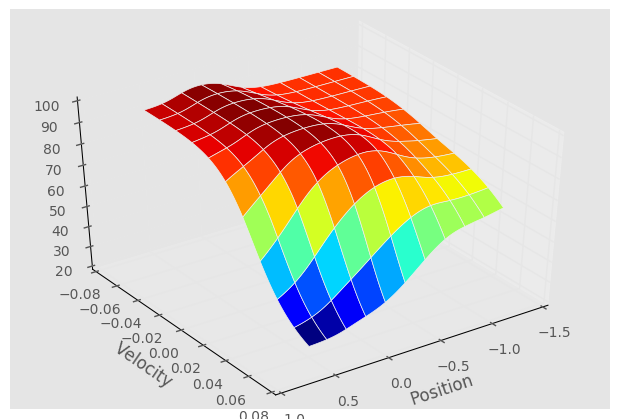

Episode: 400/1000 | Average length: 180.92

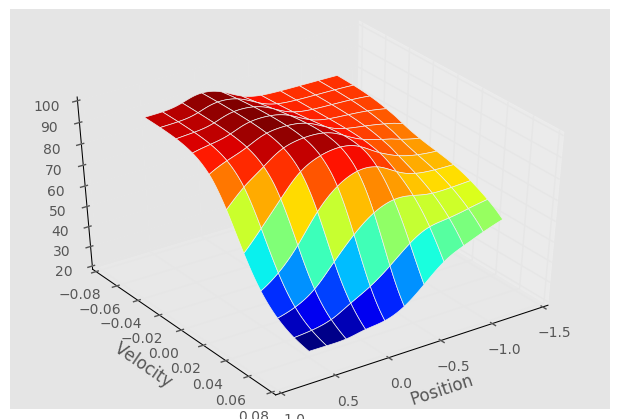

Episode: 450/1000 | Average length: 203.72

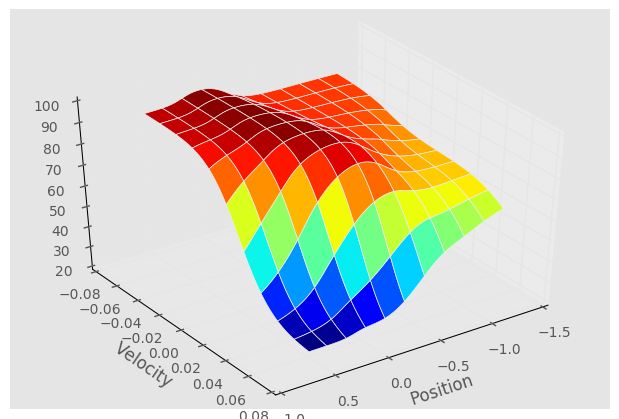

Episode: 500/1000 | Average length: 203.8

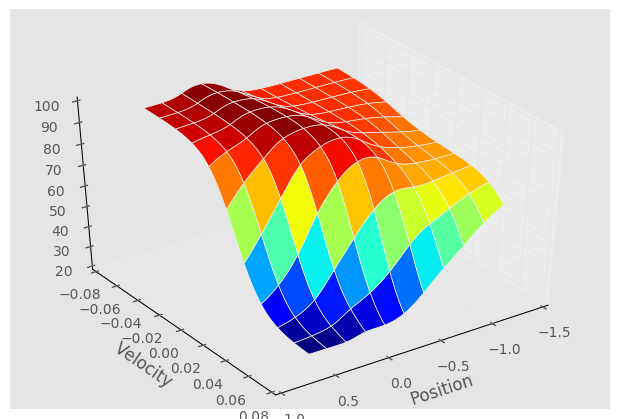

Episode: 550/1000 | Average length: 212.6

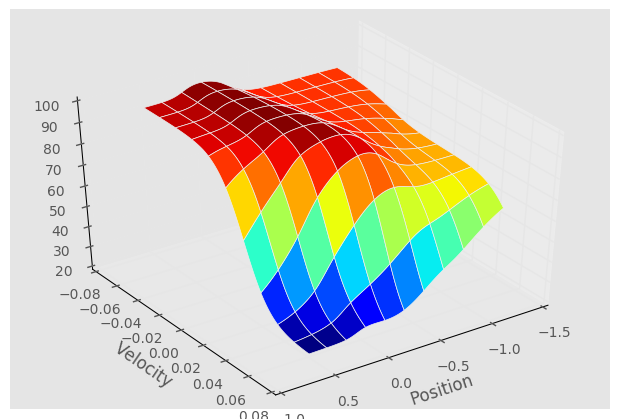

Episode: 600/1000 | Average length: 213.0

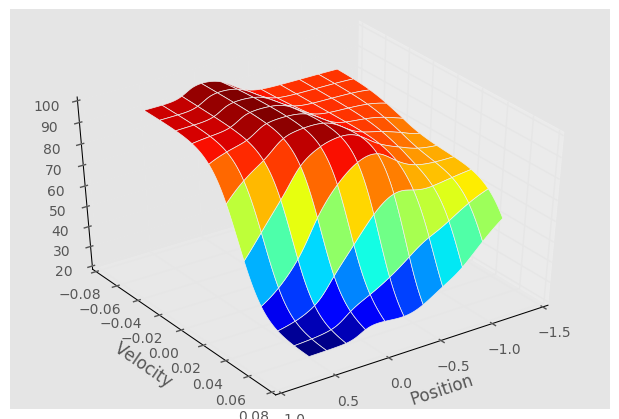

Episode: 650/1000 | Average length: 244.48

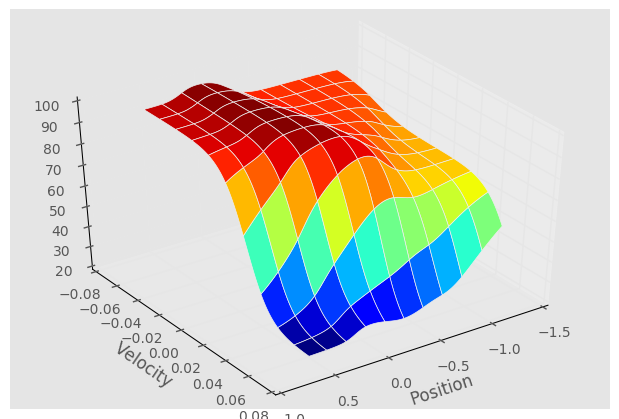

Episode: 700/1000 | Average length: 207.76

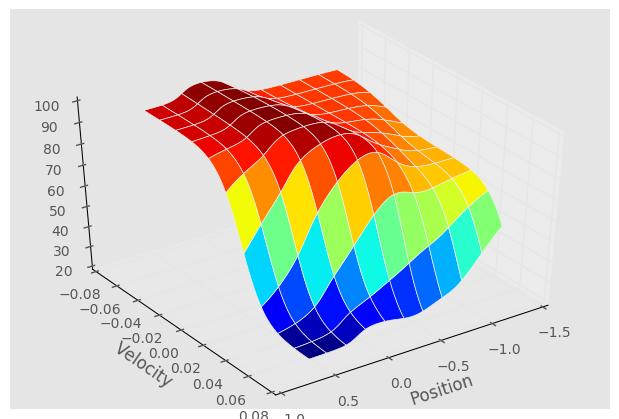

Episode: 750/1000 | Average length: 212.64

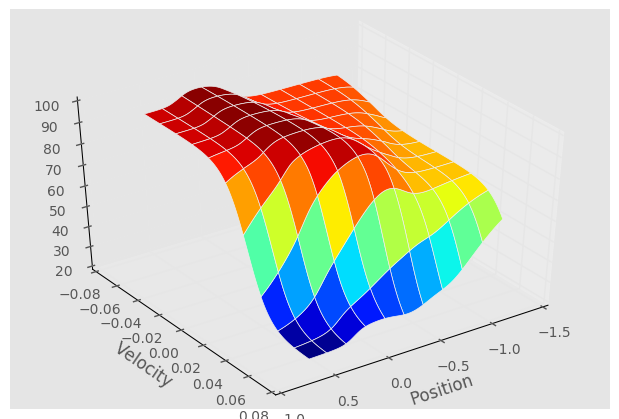

Episode: 800/1000 | Average length: 211.8

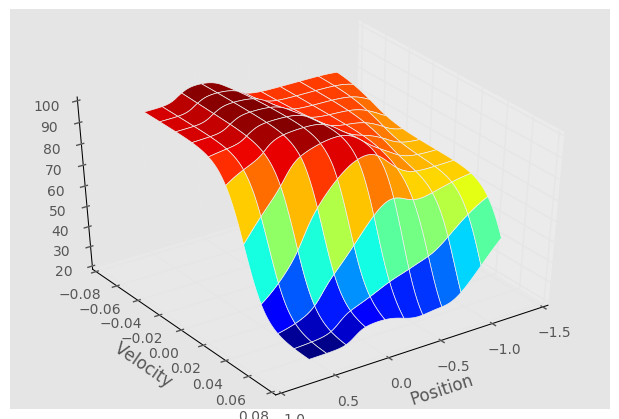

Episode: 850/1000 | Average length: 275.14

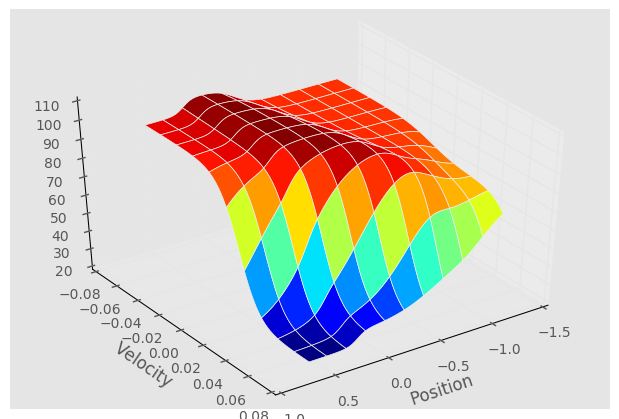

Episode: 900/1000 | Average length: 2418.34

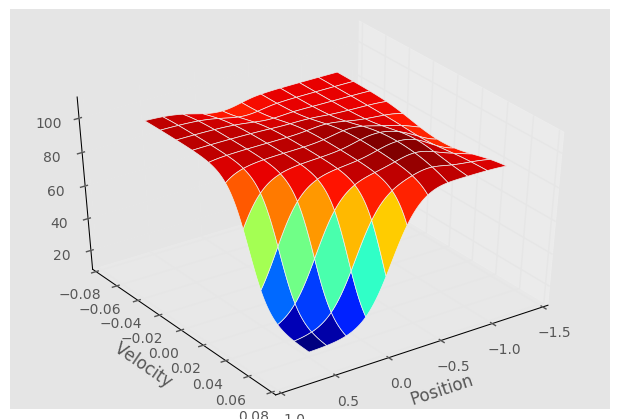

Episode: 950/1000 | Average length: 359.0

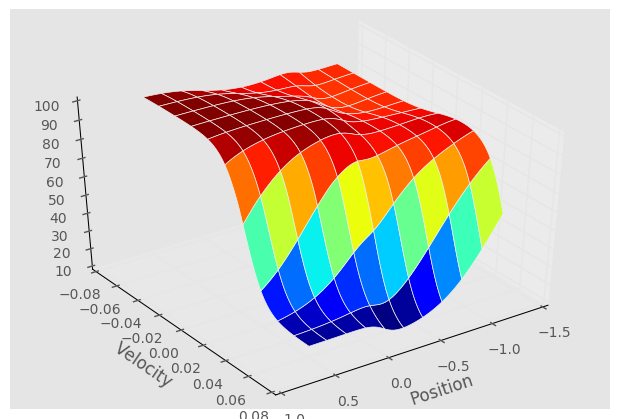

Episode: 1000/1000 | Average length: 210.34

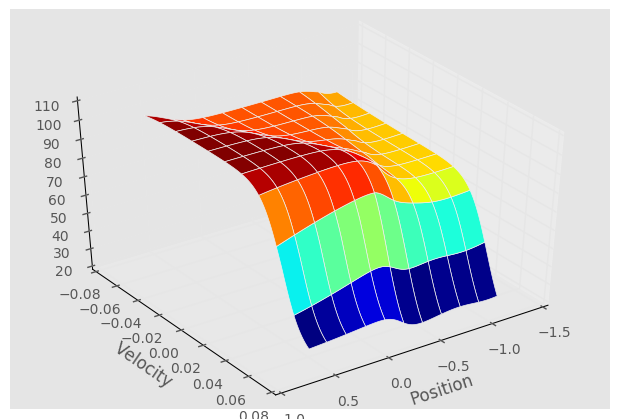

In [10]:
ep_length = train(n_episodes=1000, learning_rate=3e-3)

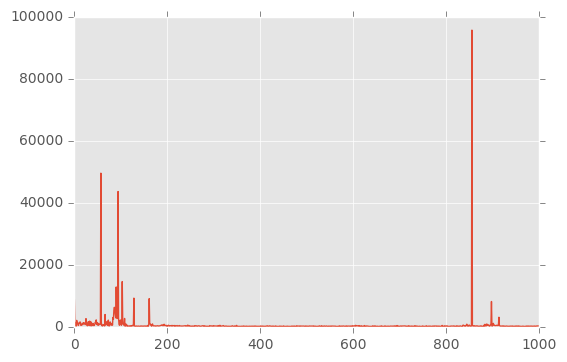

In [11]:
plt.plot(ep_length)